In [2]:
# 1. IMPORTS
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
import uuid

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten,
    Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 2. PATHS
BASE_PATH = r"ADD YOUR FOLDER PATH HERE"
ORIGINAL_PATH = os.path.join(BASE_PATH, "Original")
RETOUCHED_PATH = os.path.join(BASE_PATH, "Retouched")

for p in ["ADD REAL PATH HERE", "ADD TEMP FILE PATH HERE"]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"❌ Folder not found: {p}")

IMG_SIZE = (128, 128)

In [10]:
# 3. ELA FUNCTION (FINAL)
"""(def convert_to_ela_image(path, quality=90):
    
    Convert image to Error Level Analysis (ELA) representation.
    
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Image not found: {path}")

    original = Image.open(path).convert("RGB")

    temp_path = f"temp_ela_{uuid.uuid4().hex}.jpg"
    original.save(temp_path, "JPEG", quality=quality)
    compressed = Image.open(temp_path)

    ela_image = ImageChops.difference(original, compressed)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema]) or 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    ela_image = ela_image.resize(IMG_SIZE)

    os.remove(temp_path)

    return np.array(ela_image, dtype=np.float32)

# FORGERY REGION DETECTION (mask)
def get_forgery_mask(ela_array, threshold=30):
    # Create a binary mask of suspected forged regions from ELA image.
    
    ela_uint8 = ela_array.astype(np.uint8)

    gray = cv2.cvtColor(ela_uint8, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

    return mask


# HIGHLIGHT FORGED REGION (overlay)
def overlay_forgery(original_path, mask):
    
    # Overlay red region on forged areas.
   
    img = cv2.imread(original_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    overlay = img.copy()
    overlay[mask > 0] = [255, 0, 0]

    highlighted = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)
    return highlighted)
    """
    
def convert_to_ela_image(path, quality=90, img_size=(128,128)):
    """
    Convert image to Error Level Analysis (ELA).
    """
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Image not found: {path}")

    original = Image.open(path).convert("RGB")

    temp_path = f"temp_ela_{uuid.uuid4().hex}.jpg"
    original.save(temp_path, "JPEG", quality=quality)
    compressed = Image.open(temp_path)

    ela_image = ImageChops.difference(original, compressed)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema]) or 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    ela_image = ela_image.resize(img_size)

    os.remove(temp_path)

    return np.array(ela_image, dtype=np.float32)


def get_forgery_mask(ela_array, threshold=30):
    """
    Generate binary mask of ELA-highlighted regions.
    """
    assert ela_array.ndim == 3, "ELA image must be HxWx3"

    ela_uint8 = ela_array.astype(np.uint8)
    gray = cv2.cvtColor(ela_uint8, cv2.COLOR_RGB2GRAY)

    _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

    return mask

In [11]:
# 4. LOAD DATASET (FINAL)

X, y = [], []

for label, folder in enumerate([ORIGINAL_PATH, RETOUCHED_PATH]):
    if not os.path.exists(folder):
        raise FileNotFoundError(f"Folder not found: {folder}")

    files = [
        f for f in os.listdir(folder)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    for file in files:
        img_path = os.path.join(folder, file)

        ela = convert_to_ela_image(img_path, quality=90)

        X.append(ela)
        y.append(label)

X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y)

indices = np.random.permutation(len(X))
X, y = X[indices], y[indices]

print("Dataset Loaded:", X.shape)
print("Class Distribution:", np.bincount(y))


Dataset Loaded: (22705, 128, 128, 3)
Class Distribution: [13438  9267]


In [12]:
# 5. BALANCE DATASET (FINAL)
# avoid duplication

if len(np.unique(y)) < 2:
    raise ValueError("Dataset must contain both classes to balance.")

min_len = min(np.sum(y == 0), np.sum(y == 1))

X_bal, y_bal = [], []

for lbl in [0, 1]:
    idx = np.where(y == lbl)[0]
    idx = np.random.choice(idx, min_len, replace=False)

    X_bal.append(X[idx])
    y_bal.append(y[idx])

X = np.concatenate(X_bal, axis=0)
y = np.concatenate(y_bal, axis=0)

shuffle_idx = np.random.permutation(len(X))
X, y = X[shuffle_idx], y[shuffle_idx]

print("Balanced Distribution:", np.bincount(y))

Balanced Distribution: [9267 9267]


In [13]:
# ----------- 6. TRAIN / VAL / TEST SPLIT (FINAL) -----------

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape, np.bincount(y_train))
print("Val  :", X_val.shape, np.bincount(y_val))
print("Test :", X_test.shape, np.bincount(y_test))

Train: (12973, 128, 128, 3) [6486 6487]
Val  : (2780, 128, 128, 3) [1390 1390]
Test : (2781, 128, 128, 3) [1391 1390]


In [14]:
# ----------- 7. CNN MODEL (FINAL) -----------
import tensorflow as tf
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    ),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


c:\Users\siroy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,442 (24.86 MB)

 Trainable params: 6,516,994 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
# ----------- 8. TRAINING -----------
"""early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)"""

class_weight = {
    0: 1.0,   # Original
    1: 1.4    # Retouched (penalize false negatives)
}

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    class_weight=class_weight
)


Epoch 1/25
406/406 ━━━━━━━━━━━━━━━━━━━━ 111s 263ms/step - accuracy: 0.6218 - loss: 0.9320 - val_accuracy: 0.4662 - val_loss: 1.3812
Epoch 2/25
406/406 ━━━━━━━━━━━━━━━━━━━━ 105s 259ms/step - accuracy: 0.6668 - loss: 0.7233 - val_accuracy: 0.6773 - val_loss: 0.6162
Epoch 3/25
406/406 ━━━━━━━━━━━━━━━━━━━━ 120s 295ms/step - accuracy: 0.6896 - loss: 0.6809 - val_accuracy: 0.7014 - val_loss: 0.5792
Epoch 4/25
406/406 ━━━━━━━━━━━━━━━━━━━━ 108s 267ms/step - accuracy: 0.7110 - loss: 0.6508 - val_accuracy: 0.6522 - val_loss: 0.6606
Epoch 5/25
406/406 ━━━━━━━━━━━━━━━━━━━━ 109s 269ms/step - accuracy: 0.7396 - loss: 0.6120 - val_accuracy: 0.6838 - val_loss: 0.6295
Epoch 6/25
406/406 ━━━━━━━━━━━━━━━━━━━━ 114s 280ms/step - accuracy: 0.7651 - loss: 0.5663 - val_accuracy: 0.7162 - val_loss: 0.5740
Epoch 7/25
406/406 ━━━━━━━━━━━━━━━━━━━━ 130s 321ms/step - accuracy: 0.7922 - loss: 0.5217 - val_accuracy: 0.7183 - val_loss: 0.5832
Epoch 8/25
406/406 ━━━━━━━━━━━━━━━━━━━━ 123s 303ms/step - accuracy: 0.8157 -

In [16]:
# ----------- 9. EVALUATION -----------
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print("Final Test Accuracy:", acc)

Final Test Accuracy: 0.7238403558731079


In [17]:
# ----------- 10. CONFUSION MATRIX -----------
"""preds = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, preds)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, preds))"""

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

preds = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, preds)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(
    y_test,
    preds,
    target_names=["Original", "Retouched"]
))



87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step
Confusion Matrix:
 [[ 935  456]
 [ 312 1078]]

Classification Report:
              precision    recall  f1-score   support

    Original       0.75      0.67      0.71      1391
   Retouched       0.70      0.78      0.74      1390

    accuracy                           0.72      2781
   macro avg       0.73      0.72      0.72      2781
weighted avg       0.73      0.72      0.72      2781



In [18]:
# ----------- 11. SAVE MODEL -----------
model.save("ela_retouch_90percent.keras")
print("Model saved successfully")

Model saved successfully


In [19]:
# use for find error paths inserted
# verify datastructure

"""
for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            print(os.path.join(root, file))
"""
from collections import defaultdict

counts = defaultdict(int)

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            if "Original" in root:
                counts["Original"] += 1
            elif "Retouched" in root:
                counts["Retouched"] += 1

print("Image counts:", dict(counts))


Image counts: {}


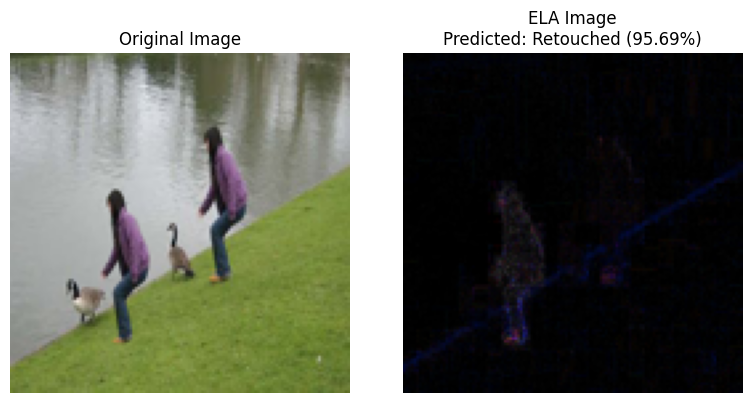

✅ Prediction: Retouched
✅ Confidence: 95.69%


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ---------------- CONFIG ----------------
TEST_IMAGE_PATH = r"ADD IMAGE PATH "
labels = {0: "Original", 1: "Retouched"}
THRESHOLD = 0.4   # tuned for better Retouched recall
# ----------------------------------------

# Check image path
if not os.path.isfile(TEST_IMAGE_PATH):
    raise FileNotFoundError(f"❌ File does not exist:\n{TEST_IMAGE_PATH}")

# Load original image (for display only)
orig = Image.open(TEST_IMAGE_PATH).convert("RGB").resize((128, 128))

# Convert to ELA
ela = convert_to_ela_image(TEST_IMAGE_PATH)
ela = ela.astype("float32") / 255.0
ela_input = ela[np.newaxis, ...]

# Model prediction
pred = model.predict(ela_input, verbose=0)[0]

# 🔥 Threshold-based decision (IMPORTANT CHANGE)
if pred[1] > THRESHOLD:
    pred_class = 1
    confidence = pred[1] * 100
else:
    pred_class = 0
    confidence = pred[0] * 100

# ---------------- VISUALIZATION ----------------
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ela)
plt.title(
    f"ELA Image\nPredicted: {labels[pred_class]} ({confidence:.2f}%)"
)
plt.axis("off")

plt.tight_layout()
plt.show()

# ---------------- OUTPUT ----------------
print("✅ Prediction:", labels[pred_class])
print(f"✅ Confidence: {confidence:.2f}%")
